<a href="https://colab.research.google.com/github/nlee98/ADS-505-Business-Analytics/blob/main/ADS_505_Final_Project_NL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADS-505 Final Project
By Group 2 - Mohammad	Mahmoudighaznavi, Nicholas Lee, and Christine	Vu

Data obtained from: https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction

In [1]:
# Packages #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV

from google.colab import files

warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
# Import Data Sets via Upload
uploaded = files.upload()

Saving airline_satisfaction_test.csv to airline_satisfaction_test.csv


In [ ]:
# Import training set
airline_train = pd.read_csv(
    "airline_satisfaction_train.csv"
)

# Import test set
airline_test = pd.read_csv(
    "airline_satisfaction_test.csv"
)

In [2]:
airline_train = pd.read_csv(
    "https://raw.githubusercontent.com/nlee98/ADS-505-Business-Analytics/main/airline_satisfaction_train.csv"
)
airline_test = pd.read_csv(
    "https://raw.githubusercontent.com/nlee98/ADS-505-Business-Analytics/main/airline_satisfaction_test.csv"
)

In [5]:
airline_train.head(3)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied


In [6]:
airline_test.head(3)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied


In [8]:
print(airline_train.shape)
print(airline_test.shape)

# Calculate Test Set Size
airline_test.shape[0]/(airline_train.shape[0] + airline_test.shape[0])

(103904, 25)
(25976, 25)


0.2

# Combine Files to One Data Set
The source had previously split the data into a training and a test set. However, the data is currently split 80:20 train:test. Because there is a large number of records, we would like to test our models with a 70:30 split.

In [12]:
airline_df = airline_train.append(airline_test, ignore_index = True)

# Confirm the correct number of rows and columns
print(airline_df.shape)
print(airline_df.columns)

(129880, 25)
Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')


# ID Columns Removal
The columns "Unnamed: 0" and "id" hold no insights into the data; they are equivalent to the dataframe indeces. For that reason, the columns can be dropped early on, lessening the number of predictors explored during exploratory data analysis.

In [13]:
# Drop ID Columns
airline_df = airline_df.drop(["Unnamed: 0", "id"], axis = 1)

# Exploratory Data Analysis (EDA)

## Missing Values

In [14]:
# Check for missing values in the data set
print(airline_df.isnull().sum())

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
satisfaction                           0
dtype: int64


There are 393 missing values, all in the predictor "Arrival Delay in Minutes."

In [15]:
# Check predictor data types are as expected
airline_df.dtypes

Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
satisfacti

Of the 23 features, there are 22 predictors and one target variable, "satisfaction." Four categorical variables make up the 22 predictors; those are Gender, Customer Type, Type of Travel and Class. The other 18 predictors are based on a 5-point likert scale. More discussion on how these will be treated, either as ordinal or numerical, later on.

## Categorical Predictors ##

### Barcharts of Customers by Gender and Customer Type 

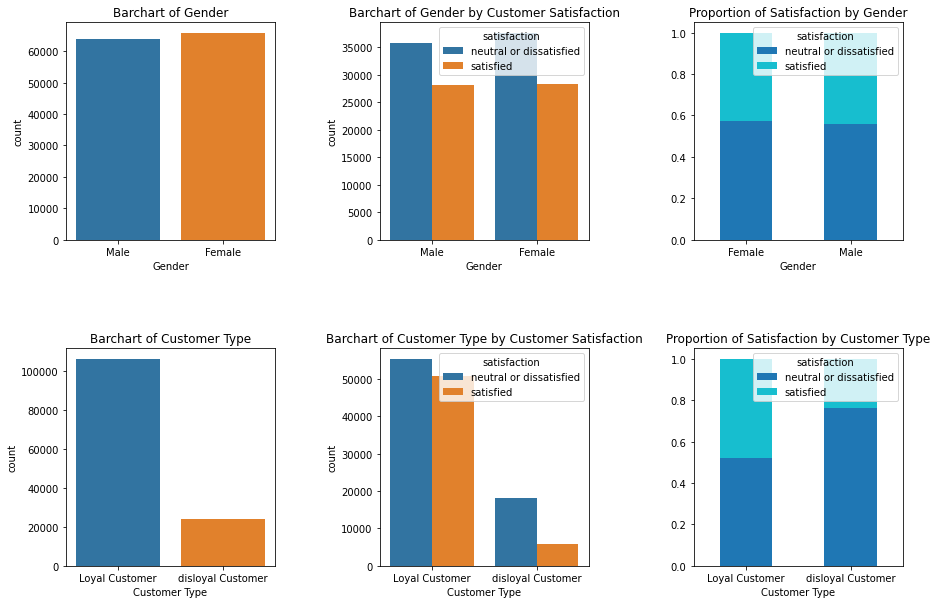

In [38]:
fig, axes = plt.subplots(
    nrows = 2,
    ncols = 3,
    figsize = (15, 10)
)

# Count of Each Gender
plt.subplot(2,3,1)
sns.countplot(x = airline_df["Gender"])
plt.title("Barchart of Gender")

# Satisfaction Rating by Gender
plt.subplot(2,3,2)
sns.countplot(x = airline_df["Gender"],
              hue = airline_df["satisfaction"]);
plt.title("Barchart of Gender by Customer Satisfaction")

# Proportion of Satisfaction Rating by Gender
gender_crosstab = pd.crosstab(airline_df["Gender"], airline_df["satisfaction"])
gender_proptab = gender_crosstab.div(gender_crosstab.sum(axis = 1), axis = 0)
gender_proptab.plot(kind = "bar", stacked = True,
                    colormap = "tab10",
                    ax = axes[0,2], rot = 0,
                    title = "Proportion of Satisfaction by Gender")

# Countplot of Customer Type
plt.subplot(2,3,4)
sns.countplot(x = airline_df["Customer Type"])
plt.title("Barchart of Customer Type")

# Count of Satisfaction Rating by Customer Type
plt.subplot(2,3,5)
sns.countplot(x = airline_df["Customer Type"],
              hue = airline_df["satisfaction"])
plt.title("Barchart of Customer Type by Customer Satisfaction")

# Propotion of Satisfaction by Customer Type
cust_proptab = pd.crosstab(index = airline_df["Customer Type"],
                           columns = airline_df["satisfaction"],
                           normalize = "index")
cust_proptab.plot(kind = "bar", stacked = True,
                  colormap = "tab10",
                  ax = axes[1,2], rot = 0,
                  title = "Proportion of Satisfaction by Customer Type")

fig.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

There is roughly the same number of males and females. Within each gender category, there is roughly the same number of neural/dissatisfied and satisfied customers. Thus, based on the plots, gender does not appear to be influencing the outcome variable.

In the data set, there are a lot more loyal customers than disloyal customers. Through the normalized bar chart of satisfaction ratings by customer type, there is a higher proportion of neutral or dissatisfied customers among disloyal customers than there are among loyal customers. This chart provides us with the initial insight that perhaps customer loyalty may affect satisfaction ratings.

### Barcharts of Type of Travel and (Ticket) Class 

satisfaction     neutral or dissatisfied  satisfied
Type of Travel                                     
Business travel                 0.416276   0.583724
Personal Travel                 0.898674   0.101326 

satisfaction  neutral or dissatisfied  satisfied
Class                                           
Business                     0.305566   0.694434
Eco                          0.812327   0.187673
Eco Plus                     0.753586   0.246414


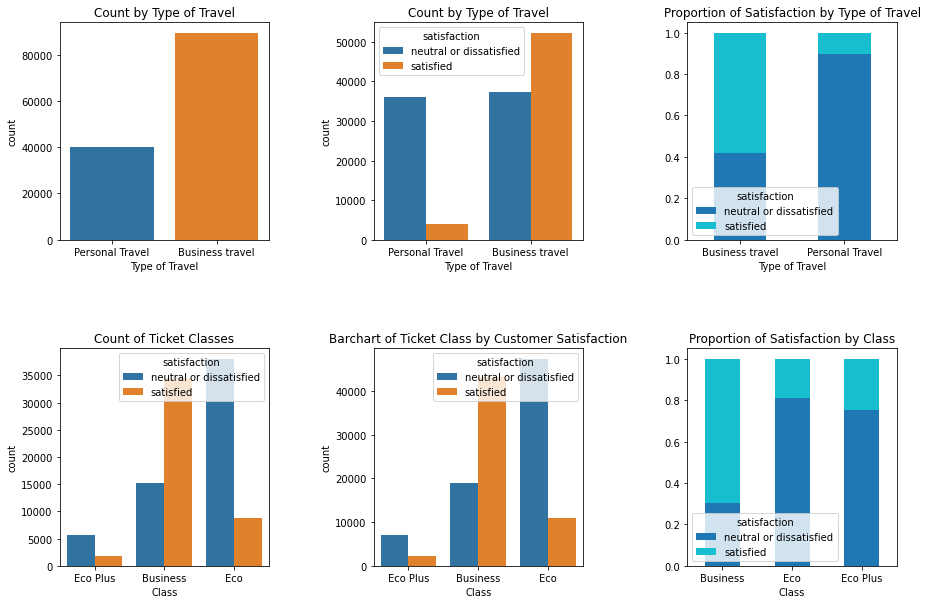

In [43]:
fig, axes = plt.subplots(
    nrows = 2,
    ncols = 3,
    figsize = (15, 10)
)
# Count Plot of Type of Travel
plt.subplot(2,3,1)
sns.countplot(x = airline_df["Type of Travel"])
plt.title("Count by Type of Travel")

# Count Plot of Satisfaction Rating by Type of Travel
plt.subplot(2,3,2)
sns.countplot(x = airline_df["Type of Travel"],
              hue = airline_df["satisfaction"])
plt.title("Count by Type of Travel")

# Proportion of satisfaction by Type of Travel
travel_proptab = pd.crosstab(index = airline_df["Type of Travel"],
                           columns = airline_df["satisfaction"],
                           normalize = "index")
travel_proptab.plot(kind = "bar", stacked = True,
                  colormap = "tab10",
                  ax = axes[0,2], rot = 0,
                  title = "Proportion of Satisfaction by Type of Travel")

# Count Plot of (Ticket) Class predictor
plt.subplot(2,3,4)
sns.countplot(x = airline_train["Class"],
              hue = airline_train["satisfaction"])
plt.title("Count of Ticket Classes")

# Count Plot of Satisfaction Rating by (Ticket) Class
plt.subplot(2,3,5)
sns.countplot(x = airline_df["Class"],
              hue = airline_df["satisfaction"])
plt.title("Barchart of Ticket Class by Customer Satisfaction")

# Proportion of satisfaction by Type of Travel
class_proptab = pd.crosstab(index = airline_df["Class"],
                           columns = airline_df["satisfaction"],
                           normalize = "index")
class_proptab.plot(kind = "bar", stacked = True,
                  colormap = "tab10",
                  ax = axes[1,2], rot = 0,
                  title = "Proportion of Satisfaction by Class")

print(travel_proptab, "\n")
print(class_proptab)

fig.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

The data set contains nearly double the number of business travelers than personal travel records. Among those travelling for business, just slightly over 40% (41.63%, exactly) are neutral or dissatisfied with the flight, while the other 58.37% are satisfied. However, amonng those travelling for personal reasons, nearly all are neutral or dissatisfied (89.86%), while the only 10% of personal travellers are satisfied with the flight.

Based on ticket class, business, economy, or economy plus, the class with the highest proportion of neutral/dissatisfied customers is the economy class (81.23%), where business class customers had the lowest proportion of dissatisfied customers (30.56%).

## Numerical Predictors

### Histogram of All Numerical Features ###

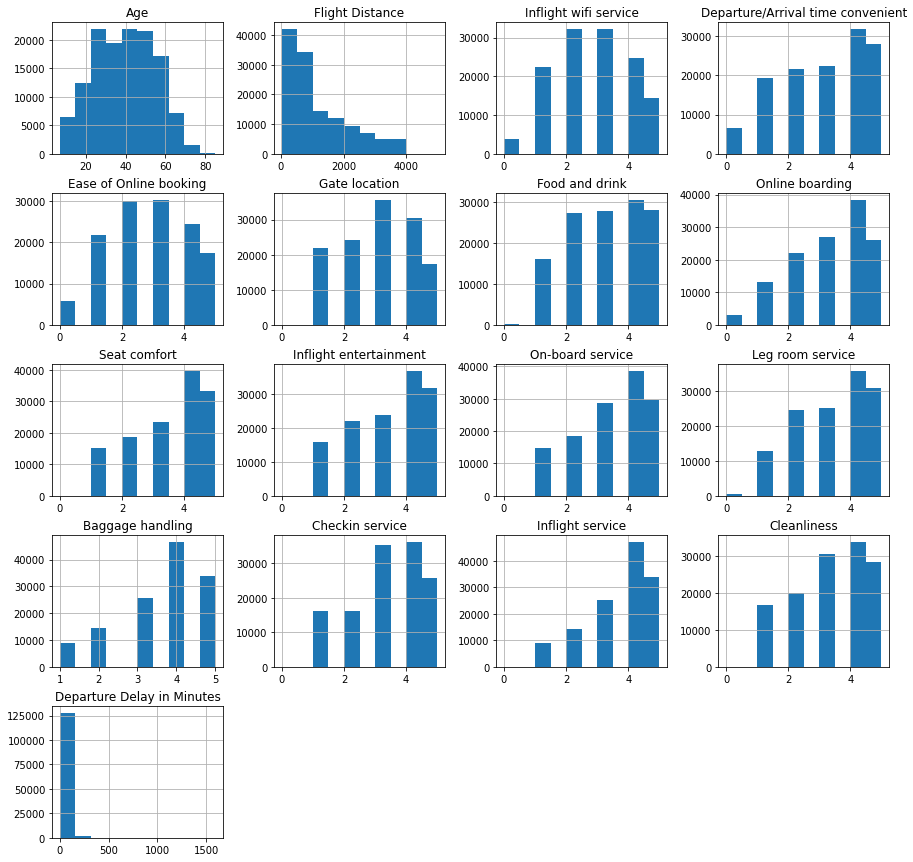

In [44]:
airline_df.select_dtypes(include = "int64").hist(figsize = (15, 15));

Many of predictors are ordinal in nature, falling on a ranking scale from 1 to 5. There is much debate about how to handle these variables. From a practical perspective, customers are ranking each predictor on a scale. Thus, there is a strong argument to treat them as ordinal variables. However, Sullivan and Artino Jr. (2013) stated that treating these predictors as numerical yields more robust results. In addition, treating the 5-point scale as numerical retains the underlying relationship that an increase in value corresponds to an increase in customer satisfaction with the predictor. For that reason, the predictors on a 5-point likert scale will be treated as numerical.

**Reference**
Sullivan, G. M., & Artino Jr, A. R. (2013). Analyzing and interpreting data from Likert-type scales. _Journal of graduate medical education, 5_(4), 541-542.
https://meridian.allenpress.com/jgme/article/5/4/541/34037/Analyzing-and-Interpreting-Data-From-Likert-Type

### Distribution of Age

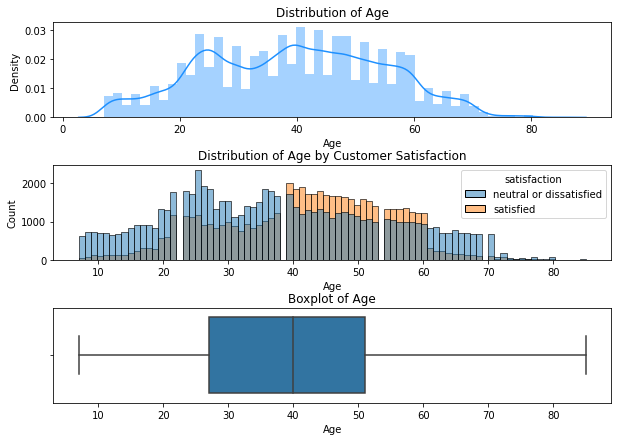

The median age is 40.0000
The average age is 39.4280


In [49]:
fig, axes = plt.subplots(
    nrows = 3,
    ncols = 1,
    figsize = (10, 7)
)

plt.subplot(3,1,1)
sns.distplot(airline_df["Age"],
             color = "dodgerblue")
plt.title("Distribution of Age")

plt.subplot(3,1,2)
sns.histplot(x = airline_df["Age"],
            hue = airline_df["satisfaction"]);
plt.title("Distribution of Age by Customer Satisfaction")

plt.subplot(3,1,3)
sns.boxplot(airline_df["Age"])
plt.title("Boxplot of Age")

fig.subplots_adjust(hspace = 0.5)
plt.show()

# Descriptive Statistics to Assess Normality
age_median = np.median(airline_df["Age"])
age_avg = np.average(airline_df["Age"])
print("The median age is %.4f" % age_median)
print("The average age is %.4f" % age_avg)

The histogram of age suggests that there may be some underlying predictor for customer satisfaction based on how old the customer is. For example, customers under the age of 39 or 40 appear to have more neural/disatisfied customers than satisfied customers. Customers between the ages of 40 and 60 appear to be  more satisfied than dissatisfied.

### Distribution of Numerical (non-likert scale) Predictors
Predictors: Flight Distance, Departure Delay, Arrival Delay

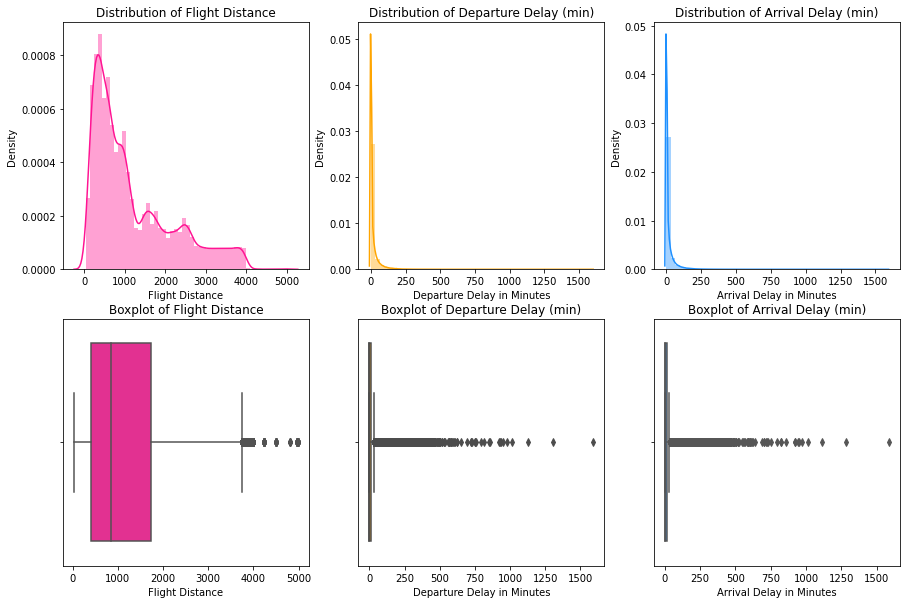

In [68]:
# Histogram of Flight Distance
fig, axes = plt.subplots(
    nrows = 2,
    ncols = 3,
    figsize = (15, 10)
)

# Flight Distance
plt.subplot(2,3,1)
sns.distplot(airline_df["Flight Distance"],
             color = "deeppink")
plt.title("Distribution of Flight Distance")

plt.subplot(2,3,4)
sns.boxplot(airline_df["Flight Distance"],
            color = "deeppink")
plt.title("Boxplot of Flight Distance")

# Departure Delay
plt.subplot(2,3,2)
sns.distplot(airline_df["Departure Delay in Minutes"],
             color = "orange")
plt.title("Distribution of Departure Delay (min)")

plt.subplot(2,3,5)
sns.boxplot(airline_df["Departure Delay in Minutes"],
            color = "orange")
plt.title("Boxplot of Departure Delay (min)")

# Arrival Delay
plt.subplot(2,3,3)
sns.distplot(airline_df["Arrival Delay in Minutes"],
             color = "dodgerblue")
plt.title("Distribution of Arrival Delay (min)")

plt.subplot(2,3,6)
sns.boxplot(airline_df["Arrival Delay in Minutes"],
            color = "dodgerblue")
plt.title("Boxplot of Arrival Delay (min)")

plt.show()

The features above are skewed right. The departure and arrival delay (in minutes) predictors are heavily skewed right due to the few instance in which flights were severely deplayed. It is important to keep all instances as heavy delays may be an indicator for satisfaction rating. Thus, before removal of outliers, transformations will be appleid to try to resolve skewness.

### Log + 1 Transformation of Numerical Predictors

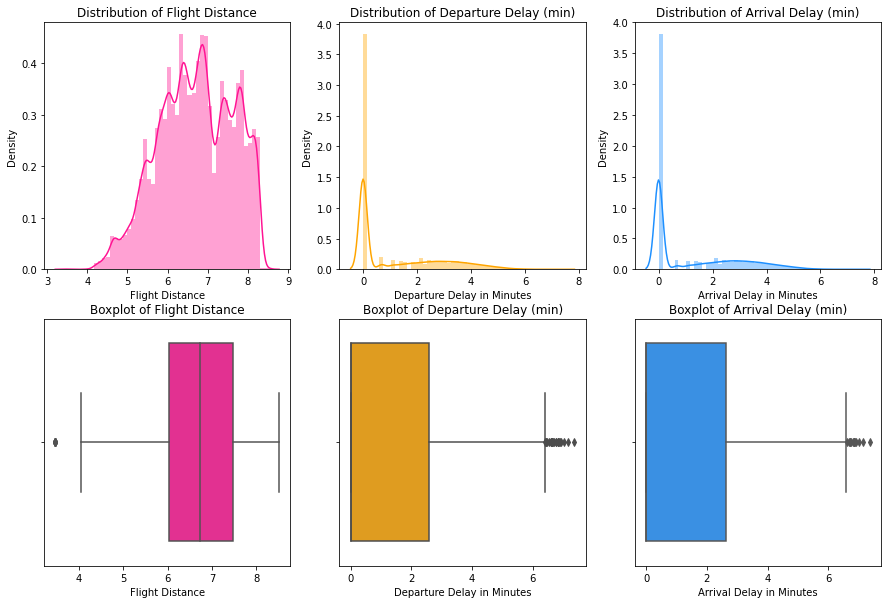

In [75]:
# Histogram of Flight Distance
fig, axes = plt.subplots(
    nrows = 2,
    ncols = 3,
    figsize = (15, 10)
)

# Flight Distance
plt.subplot(2,3,1)
sns.distplot(np.log(airline_df["Flight Distance"] + 1),
             color = "deeppink")
plt.title("Distribution of Flight Distance")

plt.subplot(2,3,4)
sns.boxplot(np.log(airline_df["Flight Distance"] + 1),
            color = "deeppink")
plt.title("Boxplot of Flight Distance")

# Departure Delay
plt.subplot(2,3,2)
sns.distplot(np.log(airline_df["Departure Delay in Minutes"] + 1),
             color = "orange")
plt.title("Distribution of Departure Delay (min)")

plt.subplot(2,3,5)
sns.boxplot(np.log(airline_df["Departure Delay in Minutes"] + 1),
            color = "orange")
plt.title("Boxplot of Departure Delay (min)")

# Arrival Delay
plt.subplot(2,3,3)
sns.distplot(np.log(airline_df["Arrival Delay in Minutes"] + 1),
             color = "dodgerblue")
plt.title("Distribution of Arrival Delay (min)")

plt.subplot(2,3,6)
sns.boxplot(np.log(airline_df["Arrival Delay in Minutes"] + 1),
            color = "dodgerblue")
plt.title("Boxplot of Arrival Delay (min)")

plt.show()

A Log plus one transformation resolved many of the outlier issues for the delay time predictors, leaving only a handful left. The transformation also corrected all but one data point, on the lower end, for the predictor Flight Distance.

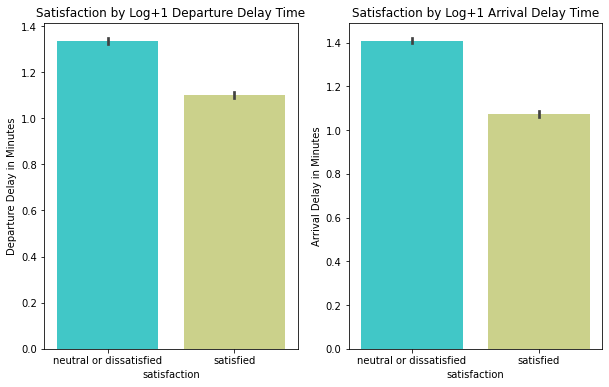

In [83]:
# Satisfaction Ratings by Delay Time
fig, axes = plt.subplots(
    nrows = 1,
    ncols = 2,
    figsize = (10,6)
)

# Satisfaction by Departure Delay
delay_log_one = np.log(airline_df["Departure Delay in Minutes"] + 1)
plt.subplot(1,2,1)
sns.barplot(x = "satisfaction",
            y = delay_log_one,
            data = airline_df,
            palette = "rainbow")
plt.title("Satisfaction by Log+1 Departure Delay Time")

# Satisfaction by Arrival Delay
arrive_log_one = np.log(airline_df["Arrival Delay in Minutes"] + 1)
plt.subplot(1,2,2)
sns.barplot(x = "satisfaction",
            y = arrive_log_one,
            data = airline_df,
            palette = "rainbow")
plt.title("Satisfaction by Log+1 Arrival Delay Time")

plt.show()

### Correlation Matrix

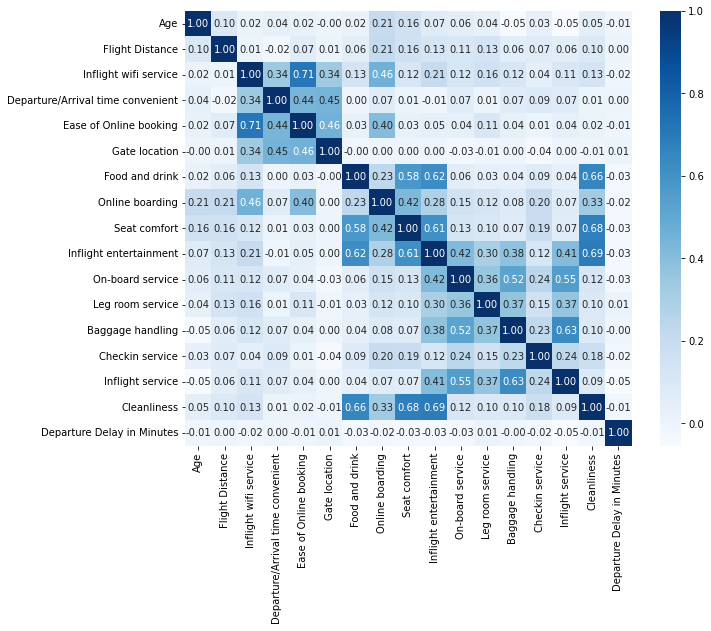

In [102]:
numerical_col = airline_df.select_dtypes(include = "int64").columns.tolist()
num_corr = airline_df[numerical_col].corr()

# Heatmap of Correlation Matrix
plt.figure(figsize = (10,8))
sns.heatmap(num_corr, annot = True,
            fmt = ".2f", 
            cmap = "Blues");
plt.show()

# Pre-Processing #

In [ ]:
# Resolve Missing Values in Arrival Delay in Minutes

In [ ]:
# Transform Flight Distance, Departure Delay in Minutes, and Arrival Delay in Minutes

In [ ]:
# Encode Gender, Customer Type, Type of Travel, Class

In [87]:
# Split into Training and Test Sets

In [ ]:
# Create Scaled Versions of Data Sets

# MinMaxScaler - Preserves original distribution


# Standard Scaler - Normal Distribution

# Model Training

## Decision Tree ##

## Random Forest ##

## Logistic Regression ##

## Linear Discriminant Analysis ##